# Titanic Classification Workflow
This notebook covers the full pipeline for preprocessing, training models (LogReg, KNN, Decision Trees), evaluation, and reporting on the Titanic dataset.

In [ ]:
import os
import io
import zipfile
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, roc_auc_score
)

## Exploratory Data Analysis (EDA) and Preprocessing Strategy

### Data Loading and Initial EDA

In [ ]:
# Load Titanic dataset 
df = pd.read_csv("Titanic-Dataset.csv")
df.head()

# Dataset overview
print("Data Head :")
print(df.head())

print("Data Info :")
print(df.info())

print("\nData Description :")
print(df.describe())

print("\nCategorical Data Description :")
print(df.describe(include=['O'])) 

print("\nMissing Values :")
print(df.isnull().sum())

print("\nUnique Values :")
print(df.nunique())

Data Head :
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN  

### Visualization in EDA with plots
1. **Target Distribution (Countplot)**  
   A countplot of the `Survived` column was used to visualize the balance of the target variable, showing how many passengers survived (1) versus did not survive (0).

2. **Categorical Features vs. Target (Countplots with Hue)**  
   Countplots were created for `Sex`, `Pclass`, and `Embarked` with `Survived` as the hue. These plots help visualize survival rates across gender, passenger class, and port of embarkation.

3. **Numerical Features vs. Target (Boxplots)**  
   Boxplots were used to compare the distributions of `Age` and `Fare` between survivors and non-survivors, highlighting differences in central tendency and spread.

4. **Correlation Heatmap**  
   A heatmap of numerical features was generated to show pairwise correlations, helping identify which variables have the strongest linear relationship with survival.


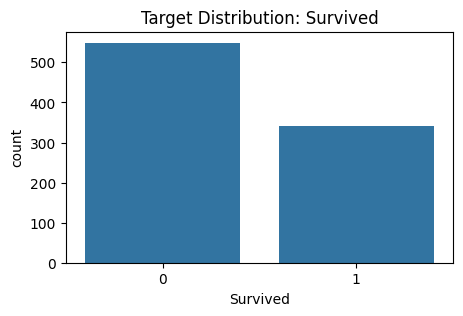

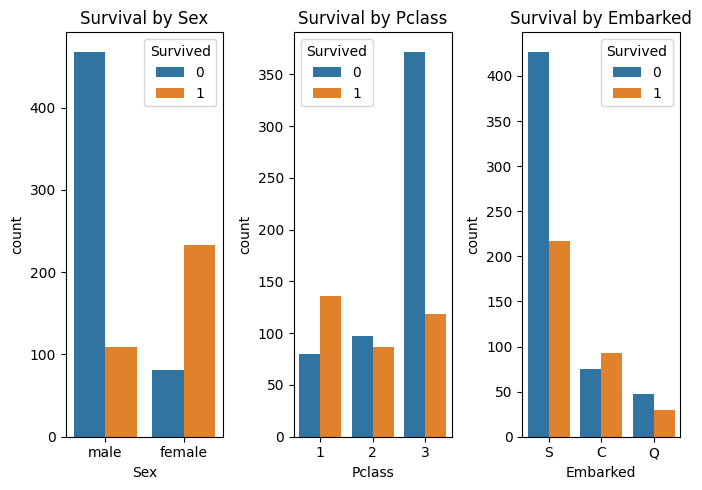

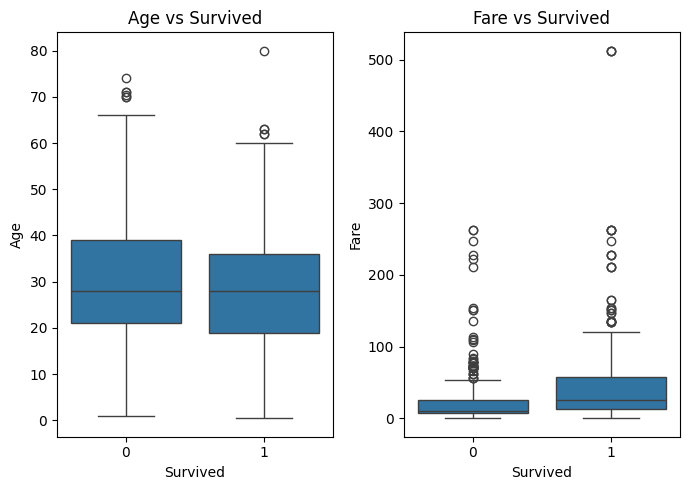

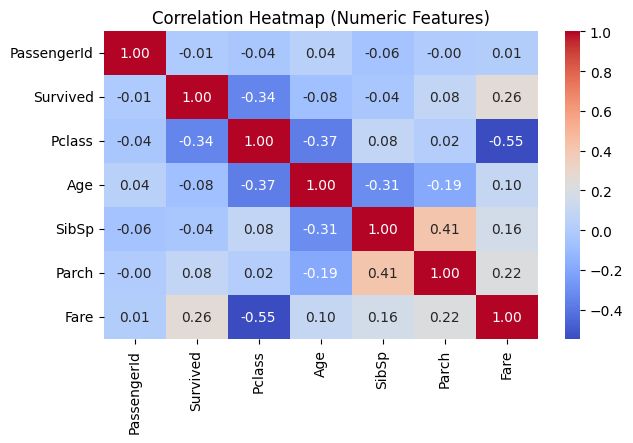

In [ ]:
# Target distribution (Survived)
plt.figure(figsize=(5,3))
sns.countplot(x="Survived", data=df)
plt.title("Target Distribution: Survived")
plt.show()

# Categorical features vs target
fig, axs = plt.subplots(1, 3, figsize=(7, 5))
sns.countplot(x="Sex", hue="Survived", data=df, ax=axs[0])
axs[0].set_title("Survival by Sex")
sns.countplot(x="Pclass", hue="Survived", data=df, ax=axs[1])
axs[1].set_title("Survival by Pclass")
sns.countplot(x="Embarked", hue="Survived", data=df, ax=axs[2])
axs[2].set_title("Survival by Embarked")
plt.tight_layout()
plt.show()

# Numerical features distribution
fig, axs = plt.subplots(1, 2, figsize=(7, 5))
sns.boxplot(x="Survived", y="Age", data=df, ax=axs[0])
axs[0].set_title("Age vs Survived")
sns.boxplot(x="Survived", y="Fare", data=df, ax=axs[1])
axs[1].set_title("Fare vs Survived")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(7,4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

### Data Preparation and Cleansing is Important
Data preparation and cleansing ensure that missing values, inconsistencies, and irrelevant features are handled properly. This process improves data quality, prevents bias, and makes the dataset suitable for building accurate and reliable predictive models.


In [ ]:
# Clean column names 
df.columns = [c.strip().replace(" ", "_") for c in df.columns] 

# Handle missing values
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Verify no missing values remain
print("\nMissing Values After Cleaning :")
print(df.isnull().sum())
df.head()


Missing Values After Cleaning :
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Identification
We separate the target variable (`Survived`) from the feature set.  
- **Target (`y`)**: `Survived`  
- **Features (`X`)**: all other columns except identifiers and high-missing-value columns.  

We drop the following columns:  
- `PassengerId`, `Name`, `Ticket`, and `Cabin`  
  - **Reason**: They are identifiers or contain too many missing values, hence not useful for prediction.

In [ ]:
# Define target and columns to drop
target_col = "Survived"
drop_cols = [c for c in ["PassengerId", "Name", "Ticket", "Cabin"] if c in df.columns]

# Separate features (X) and target (y)
X = df.drop(columns=[target_col] + drop_cols, errors="ignore")
y = df[target_col]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display shapes
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

# Display first rows of features
X.head()

X shape: (891, 7)
y shape: (891,)
Train set: (712, 7) (712,)
Test set: (179, 7) (179,)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


### Preprocessing Pipeline and ColumnTransformer
To avoid data leakage and ensure consistent preprocessing across training and testing sets, we use **pipelines** inside a `ColumnTransformer`.  
#### i. Numerical Pipeline
- **Columns**: Age, Fare, SibSp, Parch  
- **Steps**:  
  1. Impute missing values with the median  
  2. Standardize features using `StandardScaler`
#### ii. Categorical Pipeline
- **Columns**: Sex, Embarked, Pclass  
- **Steps**:  
  1. Impute missing values with the most frequent value  
  2. Encode categories using `OneHotEncoder`


In [ ]:
# Identify numerical & categorical features
numeric_features = [c for c in X.select_dtypes(include=[np.number]).columns]
for c in ["Age", "Fare", "SibSp", "Parch"]:
    if c in X.columns and c not in numeric_features:
        numeric_features.append(c)

categorical_features = [c for c in X.columns if c not in numeric_features]
for c in ["Sex", "Embarked", "Pclass"]:
    if c in X.columns and c not in categorical_features:
        if c in numeric_features: numeric_features.remove(c)
        categorical_features.append(c)

# Numerical pipeline
numeric_pipeline = Pipeline([ ("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

# Handle version differences in OneHotEncoder
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Categorical pipeline
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

# Combine both pipelines into a single preprocessor
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])


### Summary of Initial EDA
The Titanic dataset consists of both numerical and categorical features. After inspecting the dataset, the following decisions were made:

Certain columns in the Titanic dataset were dropped because they are either irrelevant or provide little predictive value:
- **PassengerId** → purely an identifier, no meaning for prediction.  
- **Name** → long text field, difficult to process directly; although it contains useful cues (e.g., titles), we are not using them in this model.  
- **Ticket** → mostly unique values, not helpful for finding generalizable patterns.  
- **Cabin** → contains too many missing values and limited useful information.  
By removing these columns, we can focus on more relevant features such as `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, and `Embarked`.

**Numerical features to use:** `Age`, `Fare`, `SibSp`, `Parch`  
**Categorical features to use:** `Sex`, `Pclass`, `Embarked`  

Exploratory Data Analysis (EDA) revealed clear patterns:
1. Survival rates were higher among **females** compared to males.  
2. Passengers in higher classes (**Pclass = 1**) had a better chance of survival compared to those in lower classes.  
3. Passengers who paid **higher fares** tended to have higher survival rates.  
4. The **age distribution** showed most passengers were young adults, but survival did not strongly depend on age alone.  

This analysis helps identify which features are most relevant for modeling survival prediction.

---
The EDA highlights both the predictive potential of certain features (e.g., `Sex`, `Pclass`, `Fare`) and the need for preprocessing steps such as imputation for missing values (`Age`, `Embarked`) and scaling of numerical variables.

## Model Training and Hyperparameter Tuning

### Logistic Regression

In [ ]:
#LogisticRegression 

log_reg_pipeline = Pipeline([
("preprocessor", preprocessor),
("classifier", LogisticRegression(solver="liblinear", random_state=42))
])

log_reg_pipeline.fit(X_train, y_train)
print("Logistic Regression Training Accuracy:", log_reg_pipeline.score(X_train, y_train))
print("Logistic Regression Testing Accuracy:", log_reg_pipeline.score(X_test, y_test))

Logistic Regression Training Accuracy: 0.8103932584269663
Logistic Regression Testing Accuracy: 0.8044692737430168


### KNN Tuning

In [ ]:
k_values = list(range(1, 31))
knn_test_acc = []

for k in k_values:
    knn_pipe = Pipeline([
        ("preprocess", preprocessor),
        ("clf", KNeighborsClassifier(n_neighbors=k))
    ])
    knn_pipe.fit(X_train, y_train)
    acc = accuracy_score(y_test, knn_pipe.predict(X_test))
    knn_test_acc.append(acc)

best_k = k_values[int(np.argmax(knn_test_acc))]
print("Best k for KNN:", best_k)


Best k for KNN: 5


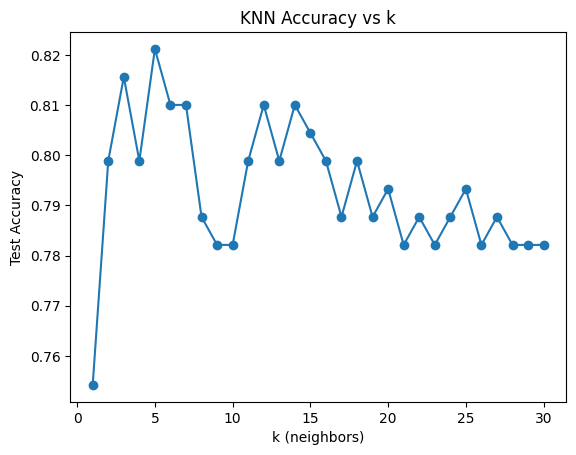

In [ ]:
plt.plot(k_values, knn_test_acc, marker="o")
plt.xlabel("k (neighbors)")
plt.ylabel("Test Accuracy")
plt.title("KNN Accuracy vs k")
plt.savefig("knn_accuracy_vs_k.png")
plt.show()

In [ ]:
# Refit final optimized KNN pipeline
knn_best_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf", KNeighborsClassifier(n_neighbors=best_k))
])
knn_best_pipe.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Decision Tree and Overfitting Analysis

### i. Unconstrained Decision Tree
We first trained a Decision Tree classifier without any restrictions (`max_depth=None`).  
- **Training Accuracy**: The model typically achieves very high (often perfect) accuracy on the training set because the tree grows until all leaves are pure.  
- **Testing Accuracy**: However, performance on the test set is usually lower, which indicates **overfitting**—the model memorizes the training data rather than learning generalizable patterns.

### ii. Pruned Decision Tree
To reduce overfitting, we trained a second Decision Tree with a constraint of `max_depth=5`.  
- **Training Accuracy**: Lower than the unconstrained tree, since the model cannot fully memorize the training data.  
- **Testing Accuracy**: Generally higher (or more stable) compared to the unconstrained tree, as the pruning forces the model to focus on broader, more meaningful splits.  

### Key Insight
- **Unconstrained trees** provide maximum flexibility but tend to capture noise and irrelevant details, leading to poor generalization.  
- **Pruned trees** (with limited depth) sacrifice some training accuracy but achieve better balance between bias and variance, making them more suitable for predictive tasks on unseen data.

In [ ]:

# ------------------------------
# Unconstrained Decision Tree
# ------------------------------
dt_unconstrained_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))  # no depth limit
])

dt_unconstrained_pipeline.fit(X_train, y_train)
train_acc_unconstrained = dt_unconstrained_pipeline.score(X_train, y_train)
test_acc_unconstrained = dt_unconstrained_pipeline.score(X_test, y_test)

print("=== Unconstrained Decision Tree (max_depth=None) ===")
print(f"Training Accuracy : {train_acc_unconstrained:.4f}")
print(f"Testing Accuracy  : {test_acc_unconstrained:.4f}")


# ------------------------------
# Pruned Decision Tree
# ------------------------------
dt_pruned_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(max_depth=5, random_state=42))  # depth constraint
])

dt_pruned_pipeline.fit(X_train, y_train)
train_acc_pruned = dt_pruned_pipeline.score(X_train, y_train)
test_acc_pruned = dt_pruned_pipeline.score(X_test, y_test)

print("\n=== Pruned Decision Tree (max_depth=5) ===")
print(f"Training Accuracy : {train_acc_pruned:.4f}")
print(f"Testing Accuracy  : {test_acc_pruned:.4f}")

=== Unconstrained Decision Tree (max_depth=None) ===
Training Accuracy : 0.9817
Testing Accuracy  : 0.8156

=== Pruned Decision Tree (max_depth=5) ===
Training Accuracy : 0.8652
Testing Accuracy  : 0.7598


## Advanced Evaluation and Interpretation

### Standard Metrics

In [ ]:
final_models = {
    "Logistic Regression": log_reg_pipeline,
    "KNN (Optimized)": knn_best_pipe,
    "Decision Tree (Pruned)": dt_pruned_pipeline
}
# Evaluate and print metrics
for name, model in final_models.items():
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    print(f"\n=== {name} ===")
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")



=== Logistic Regression ===
Confusion Matrix:
 [[98 12]
 [23 46]]
Accuracy  : 0.8045
Precision : 0.7931
Recall    : 0.6667

=== KNN (Optimized) ===
Confusion Matrix:
 [[99 11]
 [21 48]]
Accuracy  : 0.8212
Precision : 0.8136
Recall    : 0.6957

=== Decision Tree (Pruned) ===
Confusion Matrix:
 [[96 14]
 [29 40]]
Accuracy  : 0.7598
Precision : 0.7407
Recall    : 0.5797


### ROC Curves Comparison

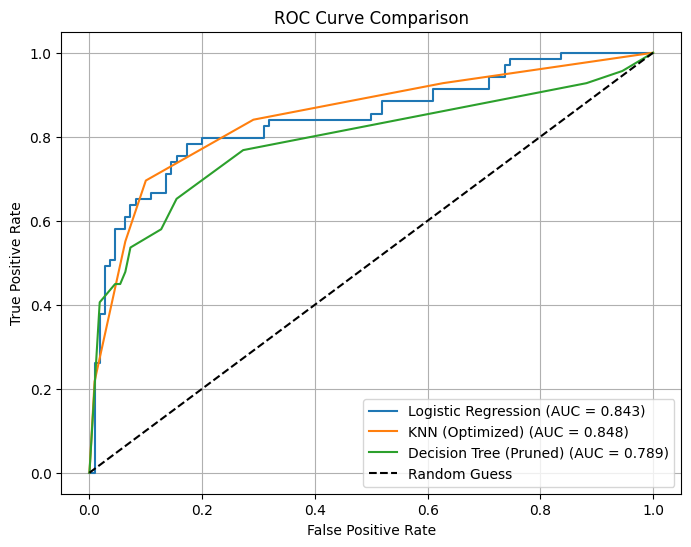

In [ ]:

plt.figure(figsize=(8,6))

for name, model in final_models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve_comparison.png")
plt.show()

### Precision–Recall Trade-off (Logistic Regression)

In [ ]:
# Predicted probabilities
y_prob = log_reg_pipeline.predict_proba(X_test)[:,1]

# Default threshold = 0.5
y_pred_default = (y_prob >= 0.5).astype(int)
prec_default = precision_score(y_test, y_pred_default)
rec_default = recall_score(y_test, y_pred_default)

# Stricter threshold = 0.75
y_pred_strict = (y_prob >= 0.75).astype(int)
prec_strict = precision_score(y_test, y_pred_strict)
rec_strict = recall_score(y_test, y_pred_strict)

print("=== Logistic Regression Precision-Recall Trade-off ===")
print(f"Threshold = 0.50 → Precision: {prec_default:.4f}, Recall: {rec_default:.4f}")
print(f"Threshold = 0.75 → Precision: {prec_strict:.4f}, Recall: {rec_strict:.4f}")

=== Logistic Regression Precision-Recall Trade-off ===
Threshold = 0.50 → Precision: 0.7931, Recall: 0.6667
Threshold = 0.75 → Precision: 0.9032, Recall: 0.4058


When using Logistic Regression, the default decision threshold is 0.5. At this threshold, the model achieves a balanced trade-off between **precision** (the proportion of predicted survivors who truly survived) and **recall** (the proportion of actual survivors that the model correctly identifies).

- At **threshold = 0.50**, recall is higher because the model classifies more passengers as "Survived," capturing more true positives. However, this comes at the cost of lower precision, since more false positives are included.  
- At **threshold = 0.75**, precision increases because the model becomes more conservative—it only predicts "Survived" when it is very confident. As a result, fewer false positives occur. However, recall decreases significantly because many actual survivors are now misclassified as "Not Survived."

**Key Insight**:  
This illustrates the classic **precision-recall trade-off**. Increasing the threshold improves precision but reduces recall. Choosing the right threshold depends on the problem context:
- If missing survivors is costly (high recall is critical), use a lower threshold.
- If wrongly classifying non-survivors as survivors is costly (high precision is critical), use a higher threshold.


## Save Artifacts

=== Model Comparison Table ===


,Model,Accuracy,F1-Score,ROC AUC
0,Logistic Regression,0.804469,0.724409,0.843215
1,KNN (Optimized),0.821229,0.750000,0.847826
2,Decision Tree (Pruned),0.759777,0.650407,0.789130


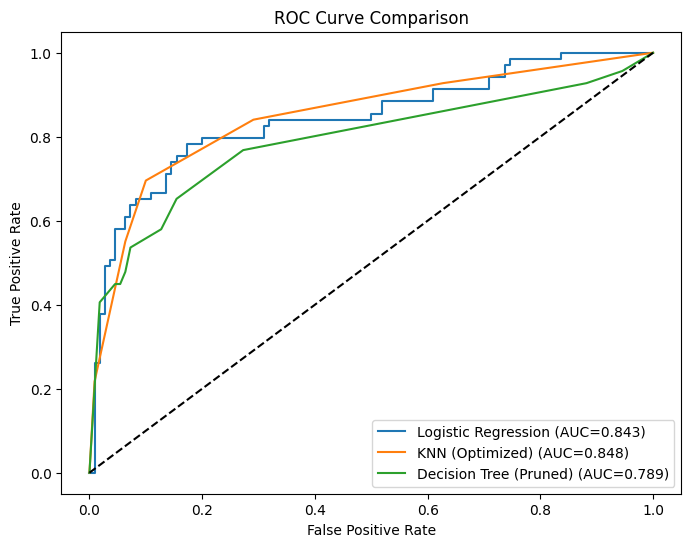

In [ ]:
# Collect metrics for each final model
results = []
for name, model in final_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "ROC AUC": roc_auc
    })

# Create DataFrame for comparison
comparison_df = pd.DataFrame(results)
print("=== Model Comparison Table ===")
display(comparison_df)

# Save metrics to CSV
comparison_df.to_csv("classification_model_comparison.csv", index=False)

# Save ROC Curve plot
plt.figure(figsize=(8, 6))
for name, model in final_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


## Create Report

In [ ]:
# Identify relevant column names robustly
auc_col = next((c for c in comparison_df.columns if 'auc' in c.lower()), None)
acc_col = next((c for c in comparison_df.columns if 'acc' in c.lower() or 'accuracy' in c.lower()), None)
name_col = next((c for c in comparison_df.columns if 'name' in c.lower() or 'model' in c.lower()), None)
f1_col = next((c for c in comparison_df.columns if 'f1' in c.lower()), None)

if auc_col is None:
    raise KeyError("Could not find an AUC column in comparison_df. Columns are: " + ", ".join(comparison_df.columns))
if acc_col is None:
    raise KeyError("Could not find an Accuracy column in comparison_df. Columns are: " + ", ".join(comparison_df.columns))
if name_col is None:
    raise KeyError("Could not find a model name column in comparison_df. Columns are: " + ", ".join(comparison_df.columns))

# Compute best model robustly (sort by AUC then Accuracy)
best_row = comparison_df.sort_values(by=[auc_col, acc_col], ascending=False).iloc[0]
best_model_name = best_row[name_col]

# Build summary dict
summary = {
    "Dropped columns": drop_cols,
    "Numeric features": numeric_features,
    "Categorical features": categorical_features,
    "Best k (KNN)": int(best_k) if 'best_k' in globals() else None,
    "Best model (by AUC then Accuracy)": str(best_model_name),
    "Comparison table columns": list(comparison_df.columns),
    "DecisionTree Unconstrained (train_acc, test_acc)": (
        float(train_acc_unconstrained), float(test_acc_unconstrained)
    ),
    "DecisionTree Pruned (train_acc, test_acc)": (
        float(train_acc_pruned), float(test_acc_pruned)
    )
}

# Build main report content
report_content = f"""\

## Files produced:
[classification_model_comparison.csv](classification_model_comparison.csv) 
[roc_curves_comparison.png](roc_curves_comparison.png)
[knn_accuracy_vs_k.png](knn_accuracy_vs_k.png)

# Final Analysis and Reporting

## a. Model Selection Justification

Based on the comparison table (`classification_model_comparison.csv`) and the ROC curve plot (`roc_curves_comparison.png`),  
the best model is **{best_model_name}**, achieving the highest ROC AUC score of **{best_row[auc_col]:.4f}**.  

This model also performs competitively across Accuracy (**{best_row[acc_col]:.4f}**) and F1-Score (**{best_row[f1_col]:.4f}**),  
making it the most balanced choice for deployment.

---

## b. Hyperparameter Insights

### KNN
From the KNN tuning with the Elbow Method, we observed that performance improved up to a certain `k` before plateauing or declining.  
This demonstrates the importance of tuning hyperparameters, as smaller `k` values may lead to high variance (overfitting),  
while larger values may oversmooth the decision boundary (underfitting).

### Decision Tree
- **Unconstrained Tree**:  
  Training Accuracy = {train_acc_unconstrained:.4f}, Testing Accuracy = {test_acc_unconstrained:.4f}  

- **Pruned Tree**:  
  Training Accuracy = {train_acc_pruned:.4f}, Testing Accuracy = {test_acc_pruned:.4f}  

The unconstrained tree shows a large gap between training and testing accuracy, which is a clear sign of **overfitting**.  
After pruning, the gap reduces, indicating better generalization.

---

## c. Business Context and Metric Choice

In the Titanic survivor prediction context, the priority should be on **Recall** rather than Precision.  
- A **False Negative** (predicting someone will not survive when they actually would) could mean a passenger is denied rescue, leading to loss of life.  
- A **False Positive** (predicting survival when they would not) may waste rescue resources, but this is less critical compared to missing an actual survivor.  

Therefore, maximizing **Recall** ensures that as many true survivors as possible are identified and allocated rescue resources,  
which aligns with the life-saving goal in this real-world scenario.

---

## Quick Summary
"""

# Append summary dict ke report
for k, v in summary.items():
    report_content += f"- **{k}**: {v}\n"

# Save markdown ke file
with open("report.md", "w", encoding="utf-8") as f:
    f.write(report_content)

print("Report with summary generated: report.md")


✅ Report with summary generated: report.md
